<a href="https://colab.research.google.com/github/BDouchet/SemanticSegmentation-Internship/blob/main/Demo_SemSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load & Process Data

Dataset have been taken from this [kaggle](https://www.kaggle.com/bulentsiyah/semantic-drone-dataset) and originally post on this [website](https://www.tugraz.at/index.php?id=22387). 
It is composed of 400 images of size 4000x6000x3 and of the associated masks divided in 20+ classes (the number of classes is not clear, the sources diverge). The images have been taken from drones and represents various environments (houses, roads, fields...). 

I manually preprocess images on my local machine : resize to 400x600 images, rename of the files and convertion to a unique .tiff format. 

I voluntary chose to split dataset in two equal datasets (train and test) in order to use data augmentation. 

In [2]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1mmBYKkgyX4cYR4Diyod3phzBRLF0eO_a'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('semantic_drone_dataset.zip')

with ZipFile('semantic_drone_dataset.zip', 'r') as zip:
   zip.extractall()
   print('Done')

Done


Visualization of a mask over its associated image. Labels are encoded on the red channel of the RGB image. Each label has an associated index, for instance 15 for people or 17 for cars. However, I did not find a table of equivalence between the indexes and their associated classes.

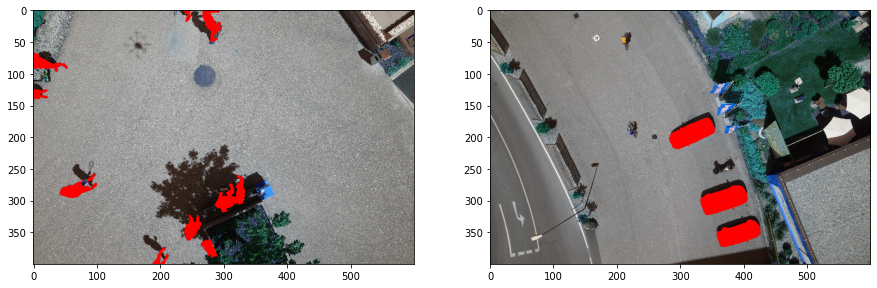

In [3]:
def visualise_over_image(img_file,mask_file,filter):
    img = cv2.imread(img_file)
    mask=cv2.imread(mask_file)[:,:,2]
    for i in filter:
        img[:,:][mask[:,:]==i]=[255,0,0]
    return img

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,8))
ax1.imshow(visualise_over_image('/content/X_train/0.tiff','/content/Y_train/0.tiff',[15]))
ax2.imshow(visualise_over_image('/content/X_train/4.tiff','/content/Y_train/4.tiff',[17]))
plt.show()

This code concerns manual data augmentation. It is composed of :

*   Adding noises randomly 
*   Variation of gamma and colors
*   Random Rotation
*   Random Crop
*   Random Splits

This function may also be doable with the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) in Keras. 

The extracted images are saved, so training is performed over the same augmented dataset.

I chose to multiply by 10 the number of training images to perform training phase with 2000 images.



In [4]:
dir_final='dataset_extended/'

if not os.path.exists(dir_final):
    os.makedirs(dir_final)
    os.makedirs(dir_final+"X_train/")
    os.makedirs(dir_final+"Y_train/")

def noise(image):
    h, w, c = image.shape
    n = np.random.randn(h, w, c) * random.randint(1, 10)
    return np.clip(image + n, 0, 255).astype(np.uint8)

# change gamma
def change_gamma(image, alpha=1, beta=0):
    return np.clip(alpha * image + beta, 0, 255).astype(np.uint8)

# change color
def color(image, alpha=10):
    n = [random.randint(-alpha, alpha), random.randint(-alpha, alpha), random.randint(-alpha, alpha)]
    return np.clip(image + n, 0, 255).astype(np.uint8)

# apply randomly the changes
def random_change(image):
    if np.random.randint(2):
        image = change_gamma(image, random.uniform(0.9, 1.1), np.random.randint(50) - 25)
    if np.random.randint(2):
        image = noise(image)
    if np.random.randint(2):
        image = color(image)
    return image

# rotate and crop image
def rotateImageandcropimg(image, angle, topleft, bottomright):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = result[topleft[1]:bottomright[1], topleft[0]:bottomright[0], :]
    return result

# rotate and crop mask
def rotateImageandcropmask(image, angle, topleft, bottomright):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_NEAREST, borderValue=-1)
    result = result[topleft[1]:bottomright[1], topleft[0]:bottomright[0], :]
    result[:, :][result[:, :, 0] == -1] = [0, 0, 0]
    return result

# operate the data augmentation and save it
def increase(n, dir_img, dir_mask, width, height, dir):
    name = 0
    for file in os.listdir(dir + dir_img):
        img = cv2.resize(cv2.imread(dir + dir_img + file), (width, height))
        img_mask_result = cv2.resize(cv2.imread(dir + dir_mask + file), (width, height),
                                     interpolation=cv2.INTER_NEAREST)
        # First add the original image
        cv2.imwrite(dir_final + 'X_train/' + str(name)+".tiff", img)
        cv2.imwrite(dir_final + 'Y_train/' + str(name)+".tiff", img_mask_result)
        name += 1

        for _ in range(n - 1):
            process = img.copy()
            process_mask = img_mask_result.copy()

            # first apply non spatial modification only on Image
            process = random_change(process)

            # Apply angle and crop modification on Image and Mask
            angle = np.random.randint(0, 20)
            scale = np.random.randint(200, 400)
            position1 = np.random.randint(0, 600 - 1.5*scale)
            position2 = np.random.randint(0, 400 - scale)
            top = [position1, position2]
            bottom = [position1 + scale, position2 + int(scale * 1.5)]
            process = rotateImageandcropimg(process, angle, top, bottom)
            process_mask = rotateImageandcropmask(process_mask, angle, top, bottom)

            # Apply randomly horizontal or vertical flips
            if np.random.randint(4) != 0:
                i = np.random.randint(3)
                process = cv2.flip(process, i - 1)  # 0 - vertical / 1 - horizontal / -1 : horizontal and vertical
                process_mask = cv2.flip(process_mask, i - 1)

            # resize for the network input
            process = cv2.resize(process, (width, height))
            process_mask = cv2.resize(process_mask, (width, height), interpolation=cv2.INTER_NEAREST)
            cv2.imwrite(dir_final + 'X_train/' + str(name)+".tiff", process)
            cv2.imwrite(dir_final + 'Y_train/' + str(name)+".tiff", process_mask)
            name += 1
            if name%100==0:
                print(str(name)+'/'+str(200*n))


dir_img = 'X_train/'
dir_mask = 'Y_train/'
width = 600
height = 400
increase(10, dir_img, dir_mask, width, height, '')

100/2000
200/2000
300/2000
400/2000
500/2000
600/2000
700/2000
800/2000
900/2000
1000/2000
1100/2000
1200/2000
1300/2000
1400/2000
1500/2000
1600/2000
1700/2000
1800/2000
1900/2000
2000/2000


Example of extraced images.

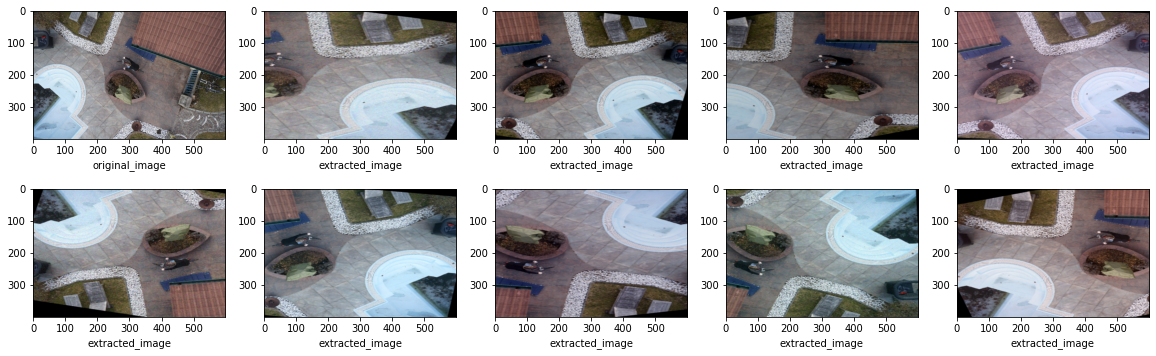

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,6))
for i, ax in enumerate(axs.flatten()):
    img=plt.imread("/content/dataset_extended/X_train/"+str(20+i)+".tiff")
    plt.sca(ax)
    plt.imshow(img)
    if i==0:
        plt.xlabel("original_image")
    else:
        plt.xlabel("extracted_image")
plt.show()

Example of extracted images with an overlay of the person. (To show the preservation of the masks in the process)

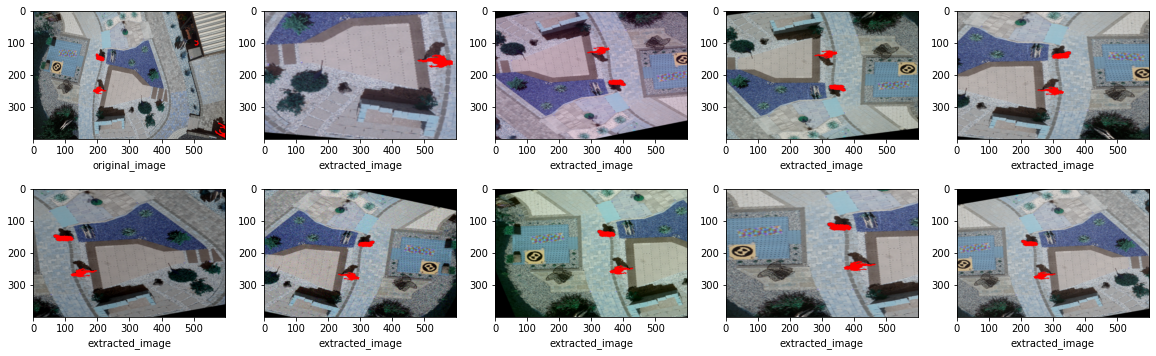

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,6))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(visualise_over_image("/content/dataset_extended/X_train/"+str(100+i)+".tiff",
                         "/content/dataset_extended/Y_train/"+str(100+i)+".tiff",
                         [15]))
    if i==0:
        plt.xlabel("original_image")
    else:
        plt.xlabel("extracted_image")
plt.show()

One-hot encoding of training masks. One-hot encoding means for each pixel we create a vector of size n, the number of classes, and the assoicated index of the class get the value 1. To get more [info](https://en.wikipedia.org/wiki/One-hot).

In [5]:
dir_final='Yh_train/'

if not os.path.exists('dataset_extended/'+dir_final):
    os.makedirs('dataset_extended/'+dir_final)

for i in os.listdir("/content/dataset_extended/Y_train/"):
    lab=cv2.imread("/content/dataset_extended/Y_train/"+i)[:,:,2]
    lab_1h = np.zeros(shape=(400,600, 20), dtype=np.uint8)
    for label in range(20):
        lab_1h[:, :, label][lab == label] = 1
    np.save("/content/dataset_extended/Yh_train/"+i,lab_1h)

Same with test masks.

In [6]:
dir_final='Yh_test/'

if not os.path.exists(dir_final):
    os.makedirs(dir_final)

for i in os.listdir("/content/Y_test/"):
    lab=cv2.imread("/content/Y_test/"+i)[:,:,2]
    lab_1h = np.zeros(shape=(400,600, 20), dtype=np.uint8)
    for label in range(20):
        lab_1h[:, :, label][lab == label] = 1
    np.save("/content/Yh_test/"+i,lab_1h)

# Create & Train model

The model used is similar to a [Unet](https://arxiv.org/abs/1505.04597) with little changes :


*   Go less deeper (OS=8 instead of 16 in the original paper)
*   Less filters (multiples of 32 instead of 64)
*   Use of residual blocks in order to increase the number of weight layers

The Architecture is the following :

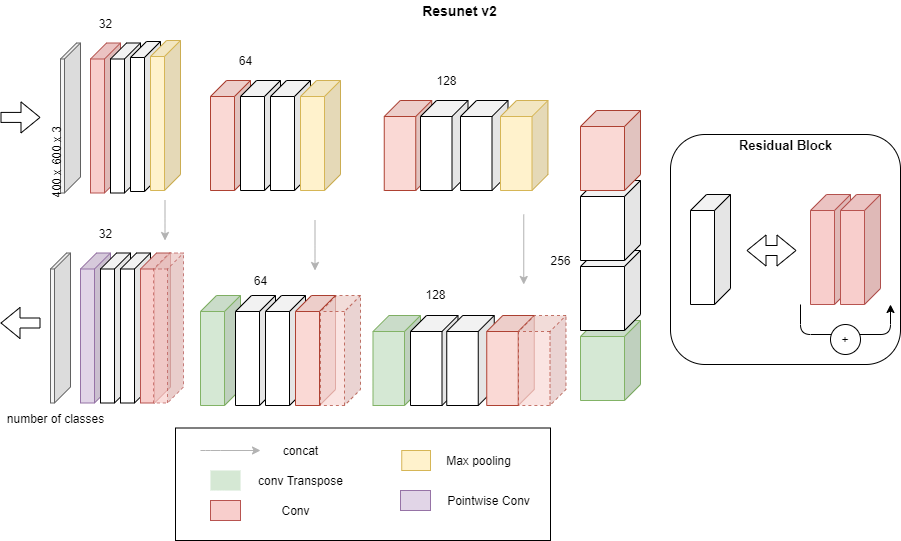

In [7]:
def resblock(x, kernelsize, depth):
    y=layers.Conv2D(depth,kernelsize,activation='relu',padding='same')(x)
    y=layers.BatchNormalization()(y)
    y=layers.Conv2D(depth,kernelsize,padding='same')(y)
    y=layers.Add()([x,y])
    y=layers.ReLU()(y)
    y=layers.BatchNormalization()(y)
    return y

def resunetv2(height=400, width=600, nbr_mask=20, nbr=32, activation='softmax'):
    # Inputimage
    entree = layers.Input(shape=(height, width, 3), dtype='float32')

    #Level0
    result = layers.Conv2D(nbr,3,activation='relu',padding='same')(entree)
    result = layers.BatchNormalization()(result)
    result=resblock(result,3,nbr)
    result1=resblock(result,3,nbr)
    result=layers.MaxPool2D()(result1)

    #level-1
    result=layers.Conv2D(2*nbr,3,activation='relu',padding='same')(result)
    result=layers.BatchNormalization()(result)
    result = resblock(result,3,2*nbr)
    result2 = resblock(result, 3, 2 * nbr)
    result=layers.MaxPool2D()(result2)

    #Level -2
    result = layers.Conv2D(4 * nbr, 3, activation='relu', padding='same')(result)
    result = layers.BatchNormalization()(result)
    result=resblock(result,3,4*nbr)
    result3 = resblock(result, 3, 4 * nbr)
    result=layers.MaxPool2D()(result3)

    #Level-3
    result = layers.Conv2D(8 * nbr, 3, activation='relu', padding='same')(result)
    result = layers.BatchNormalization()(result)
    result = resblock(result, 3, 8 * nbr)
    result = resblock(result, 3, 8 * nbr)
    result = layers.Conv2DTranspose(4*nbr,3,strides=(2,2),activation='relu',padding='same')(result)

    #Level -2
    result=layers.Concatenate()([result,result3])
    result = layers.Conv2D(4 * nbr, 3, activation='relu', padding='same')(result)
    result = layers.BatchNormalization()(result)
    result = resblock(result, 3, 4 * nbr)
    result = resblock(result, 3, 4 * nbr)
    result = layers.Conv2DTranspose(2*nbr,3,strides=(2,2),activation='relu',padding='same')(result)


    #Level-1
    result = layers.Concatenate()([result, result2])
    result = layers.Conv2D(2 * nbr, 3, activation='relu', padding='same')(result)
    result = layers.BatchNormalization()(result)
    result = resblock(result, 3, 2 * nbr)
    result = resblock(result, 3, 2 * nbr)
    result = layers.Conv2DTranspose(nbr,3,strides=(2,2),activation='relu',padding='same')(result)


    #Level0
    result = layers.Concatenate()([result, result1])
    result = layers.Conv2D(nbr, 3, activation='relu', padding='same')(result)
    result = layers.BatchNormalization()(result)
    result = resblock(result, 3, nbr)
    result = resblock(result, 3, nbr)

    #Output
    sortie = layers.Conv2D(nbr_mask, 1, activation=activation, padding='same')(result)

    model = models.Model(inputs=entree, outputs=sortie)
    return model
    
print(resunetv2().summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 600, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 600, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 600, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 600, 32) 9248        batch_normalization[0][0]        
_______________________________________________________________________________________

I create my generators for training and validation. The training generator yield inputs in a random order to prevent overfitting. For the training process, I use the following hyperparameters :
*   Batch_size=8
*   Epochs=150 (probably too much)
*   Optimizer : Adam with a learning rate=0.001
*   loss : categorical_crossentropy (DiceLoss is also a strong alternative)

I saved the model weight and optimizer and put it in the zipfile under the name "model.h5" 

In [10]:
import tensorflow.keras.backend as K

batch_size=8
step_ep=2000//batch_size

def Generator_Shuffle():
    while True:
        keys=np.arange(2000)
        np.random.shuffle(keys)
        for i in range(step_ep):
            batch_keys=keys[i*batch_size:(i+1)*batch_size]
            x_yield=[]
            y_yield=[]
            for j in batch_keys:
                x_yield.append(cv2.imread('/content/dataset_extended/X_train/'+str(j)+".tiff")/255)
                y_yield.append(np.load('/content/dataset_extended/Yh_train/'+str(j)+".tiff.npy"))
            yield np.array(x_yield), np.array(y_yield)
val_step=200//batch_size

def Generator_Test():
    while True:
        for i in range(val_step):
            x_yield=[]
            y_yield=[]
            for j in range(batch_size):
                x_yield.append(cv2.imread('/content/X_test/'+str(200+i*batch_size+j)+".tiff")/255)
                y_yield.append(np.load('/content/Yh_test/'+str(200+i*batch_size+j)+".tiff.npy"))
            yield np.array(x_yield), np.array(y_yield)

model=resunetv2()
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.001),metrics=['acc'])
history=model.fit(Generator_Shuffle(),epochs=150,steps_per_epoch=step_ep,validation_data=Generator_Test(),validation_steps=val_step)

Epoch 1/150
250/250 [==============================] - 193s 773ms/step - loss: 1.5047 - acc: 0.5620 - val_loss: 2.3310 - val_acc: 0.4077
Epoch 2/150
250/250 [==============================] - 193s 771ms/step - loss: 1.1813 - acc: 0.6035 - val_loss: 1.3124 - val_acc: 0.5670
Epoch 3/150
250/250 [==============================] - 193s 771ms/step - loss: 1.1006 - acc: 0.6189 - val_loss: 1.5324 - val_acc: 0.4738
Epoch 4/150
250/250 [==============================] - 193s 771ms/step - loss: 1.0239 - acc: 0.6421 - val_loss: 1.4777 - val_acc: 0.4666
Epoch 5/150
250/250 [==============================] - 193s 771ms/step - loss: 0.9898 - acc: 0.6487 - val_loss: 1.5416 - val_acc: 0.4979
Epoch 6/150
250/250 [==============================] - 193s 771ms/step - loss: 0.9605 - acc: 0.6553 - val_loss: 1.0157 - val_acc: 0.6359
Epoch 7/150
250/250 [==============================] - 193s 771ms/step - loss: 0.9359 - acc: 0.6619 - val_loss: 0.8935 - val_acc: 0.6829
Epoch 8/150
250/250 [====================

Plot of the training cruves.

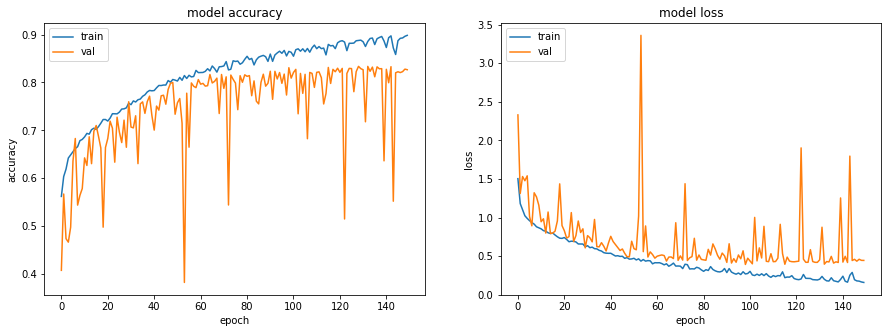

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [8]:
model=models.load_model('model.h5')

# Inference and performance

Calculation of the predictions and convertion from one_hot encoding to RGB masks.

In [9]:
y=[]
for file in os.listdir('/content/Y_test/'):
    y.append(cv2.imread('/content/Y_test/'+file))
print("Done")
x=[]
for file in os.listdir('/content/X_test/'):
    x.append(cv2.imread('/content/X_test/'+file))
print("Done")
yp=model.predict(np.array(x)/255,batch_size=8,verbose=1)
print("Done")
YP=[]
for number,pred in enumerate(yp):
    PRED=np.zeros((400,600,3))
    for i in range(400):
        for j in range(600):
            PRED[i,j,2]=np.argmax(pred[i,j])
    YP.append(PRED)
    if number%10==0:
        print(str(number)+"/200")
pred=np.array(YP,dtype='int')
print("Done")
print(pred.shape)

Done
Done
25/25 [==============================] - 7s 266ms/step
Done
0/200
10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200
Done
(200, 400, 600, 3)


Calculation of metrics to get the performance of our model :

*   **Pixel Accuracy** (PA) is the quantity of pixels well classified over the quantity of pixels. It can be interpretated as the ability to correctly detect the objects in the images (especially the case where there is a background like roads, grass...)
*   **Mean Intersection Over Union** (mIoU or Jaccard Index) is the average of IoU the classes. The IoU for a class is the intersection over the union. It can be intepretated as the ability to correctly classify the object in the images. Usually, mIoU is considered as a more relvant metric for semantic segmentation. In the following code, den stands for denominator and represents the sum of A and B. To get (A or B), we substract (A and B) to A+B.

At this point, I discovered they were more than the 20 announced classes, so the classes > 20 are considered as 0 in the calculation of the performances.

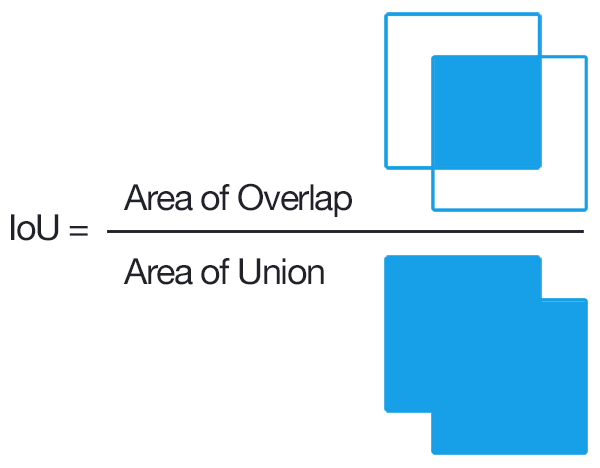


In [15]:

intersection = np.zeros(20) # int = (A and B)
den = np.zeros(20) # den = A + B = (A or B) + (A and B)
pixel_accuracy=0
for i in range(200):
    y_pred=pred[i,:,:,2]
    gt=np.array(y[i][:,:,2])
    for i in range(400):
        for j in range(600):
            if y_pred[i][j]==gt[i][j]:
                pixel_accuracy+=1
                intersection[y_pred[i][j]]+=1
            den[y_pred[i][j]] += 1
            if gt[i][j]<20:
                den[gt[i][j]]+=1
            else:
                den[0]+=1
mIoU = 0
for i in range(20):
    if den[i]!=0:
        mIoU+=intersection[i]/(den[i]-intersection[i])
    else:
        mIoU+=1
mIoU=mIoU/20
PA=pixel_accuracy / (600 * 400 * 200)
print("Total : PA = " + str(PA)+" ; mIoU = "+str(mIoU))


Total : PA = 0.8264810625 ; mIoU = 0.4429917804433794


Display the prediction and compare them to their ground truth.
Colors are generated randomly and, unfortunately, I don't have the correspondances. 

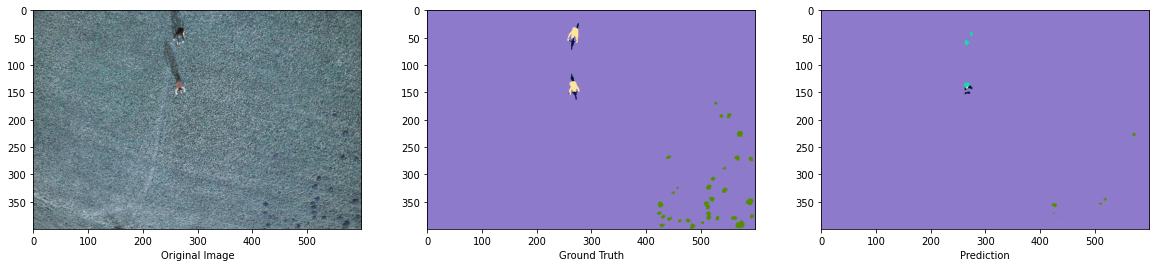

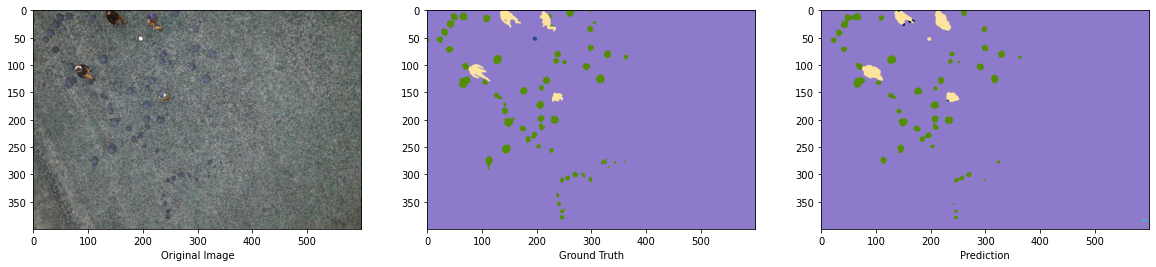

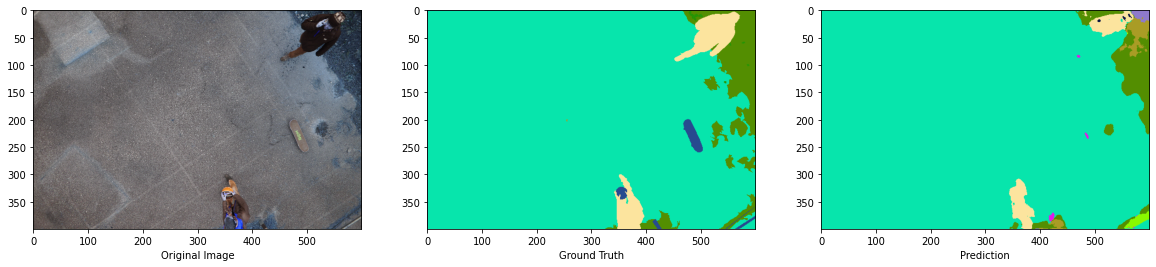

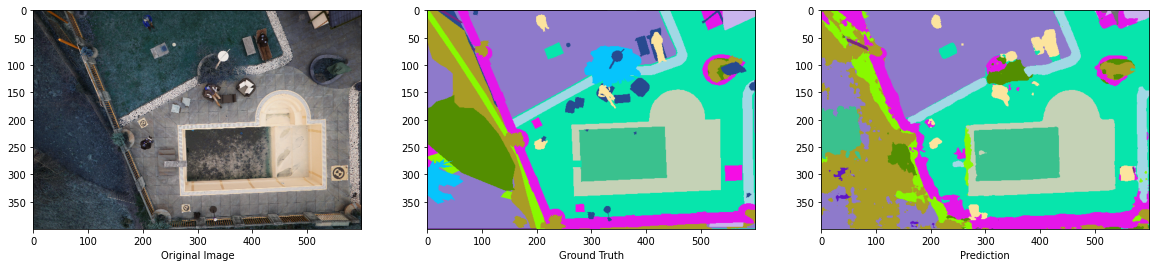

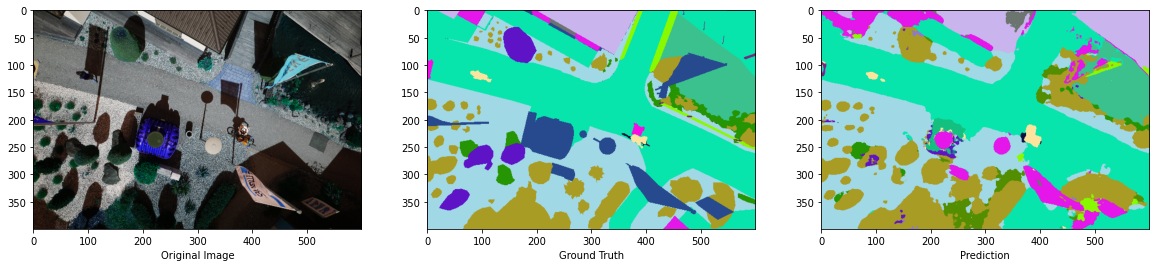

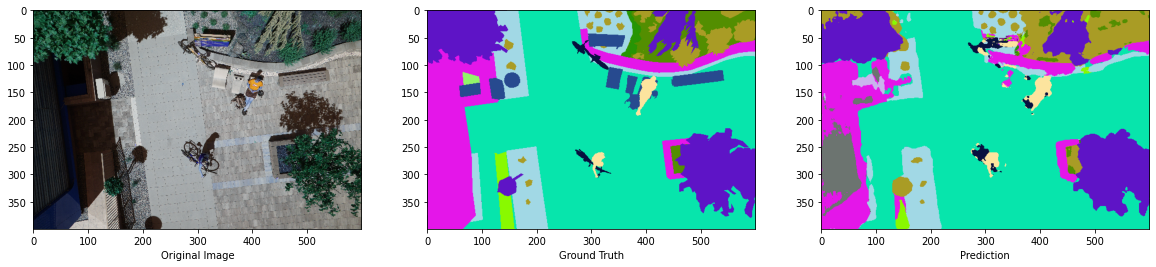

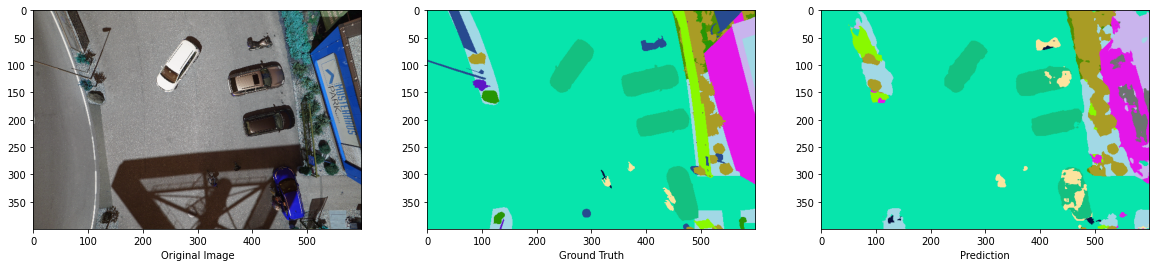

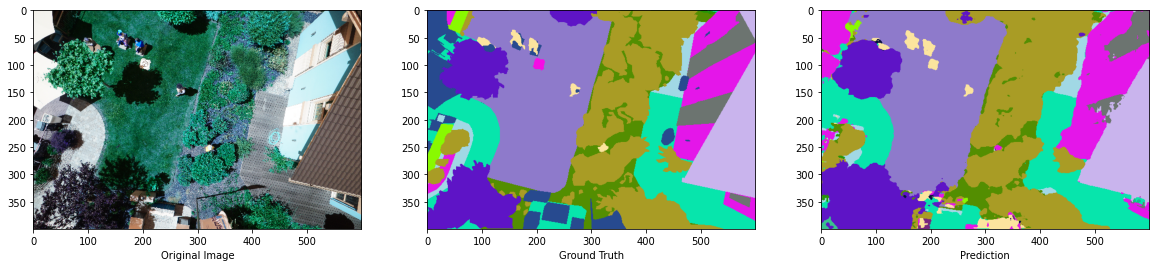

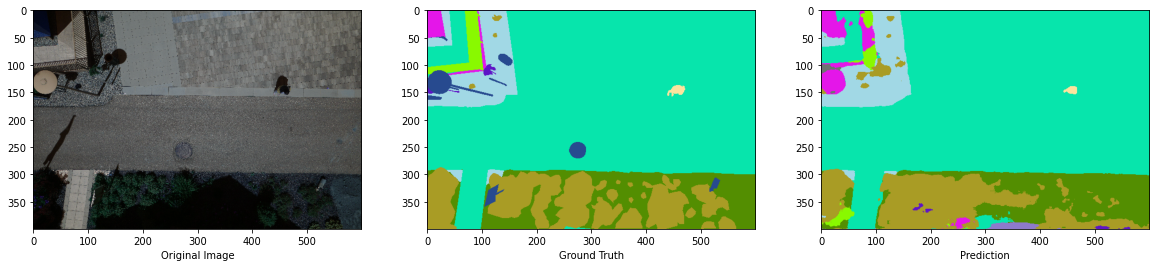

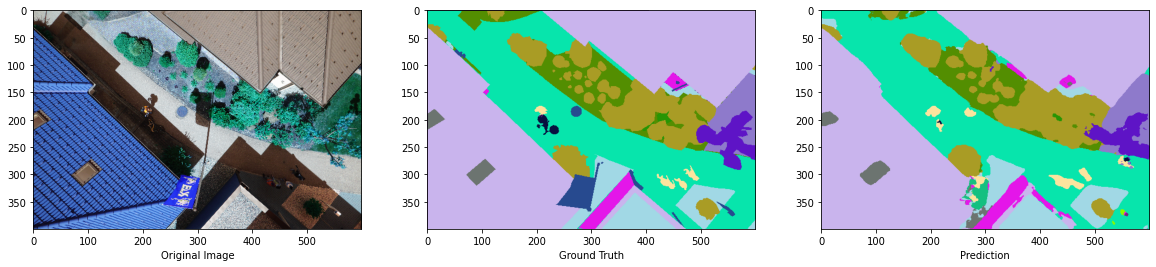

In [10]:
colors=[[random.randint(0,255),random.randint(0,255),random.randint(0,255)] for _ in range(25)]


def convert2colors(X):
    out=np.zeros((400,600,3),dtype='int')
    for i in range(400):
        for j in range(600):
            out[i,j]=colors[X[i,j,2]]

    return out

for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,6))
    ax1.imshow(x[i])
    ax1.set_xlabel("Original Image")

    ax2.imshow(convert2colors(np.array(y[i])))
    ax2.set_xlabel("Ground Truth")

    ax3.imshow(convert2colors(np.array(pred[i])))
    ax3.set_xlabel("Prediction")
        
    plt.show()

An example of the measures (in pixels) of cars on the photos

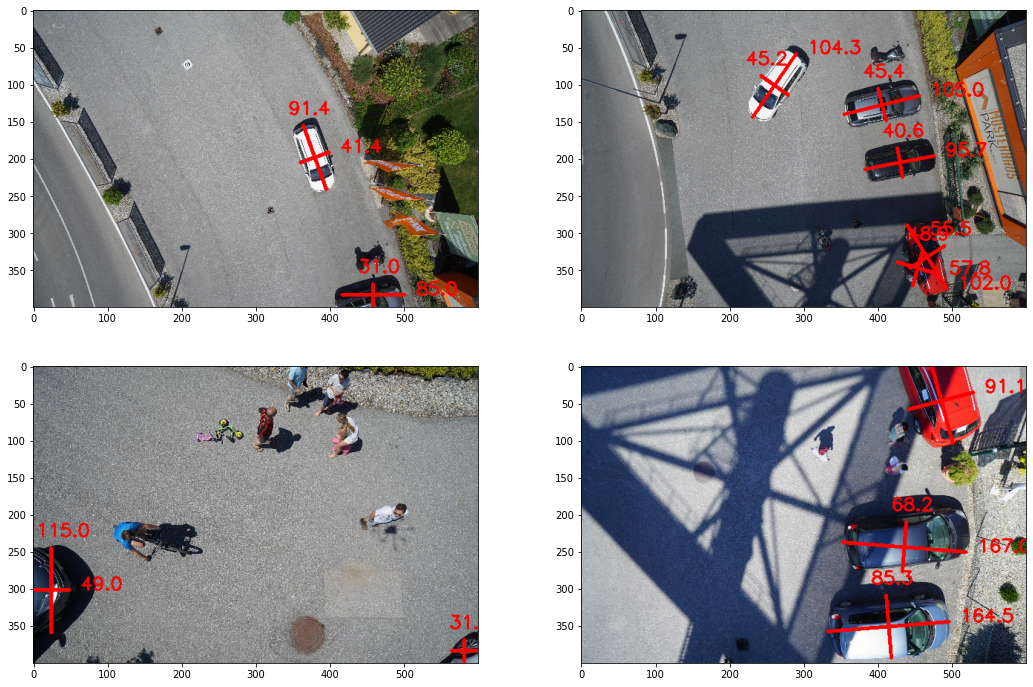

In [35]:
import imutils
from imutils import contours, perspective, grab_contours
from google.colab.patches import cv2_imshow

def centre(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def get_measures_cars(path,filter):
    image=cv2.imread(path)
    mask=model.predict(np.array([image])/255)[0]
    color=[0,0,255]

    #get the contours by applying a cany filter
    process=np.zeros((400,600,3),dtype='uint8')
    process[:,:,2]=mask[:,:,filter]*255
    edged=cv2.Canny(process,50,100)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    #I iterate over each contour
    for c in cnts:

        #I get the minimum area rectangle that shape our object
        box=cv2.minAreaRect(c)
        box = cv2.boxPoints(box)
        box = perspective.order_points(box)
        box = np.int0(box)
        #cv2.drawContours(image, [box],0, color)
        #cv2_imshow(image)
        (tl, tr, br, bl) = box
        (tltrX, tltrY) = centre(tl, tr)
        (blbrX, blbrY) = centre(bl, br)
        (tlblX, tlblY) = centre(tl, bl)
        (trbrX, trbrY) = centre(tr, br)

        #Calculation fo the size of the boudning boxe
        dA =cv2.norm((tltrX, tltrY),(blbrX, blbrY),cv2.NORM_L2)
        dB = cv2.norm((tlblX, tlblY), (trbrX, trbrY), cv2.NORM_L2)
        
        #We only keep "big" objects, otherwise a lot of small shapes are detected
        if dA>30 and dB>30: 
            cv2.line(image, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)),
                        color, 3)
            cv2.line(image, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)),
                                color, 3)
            cv2.putText(image, "{:.1f}".format(dA),
                        (int(tltrX - 20), int(tltrY - 15)), cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, color, 2)
            cv2.putText(image, "{:.1f}".format(dB),
                        (int(trbrX + 15), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                        0.8, color, 2)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

fig,axs=plt.subplots(2,2,figsize=(18,12))
names=[216,224,257,272]
for i,ax in enumerate(axs.flatten()):
    ax.imshow(get_measures_cars('/content/X_test/'+str(names[i])+'.tiff',17))

